In [1]:
import numpy as np
import math
np.set_printoptions(precision=4, suppress=True, linewidth=10000)
import matplotlib.pyplot as plt


In [2]:
#definitions

fix_bug_who_encounter = True
fix_bug_offspring = True

extinction_status = 0
warning = 0
sex = 0
sa = np.array([1, 2])
ma = np.array([3, 4])
fa = np.array([5, 6])

In [3]:
def emergencesample(T):
    p = np.random.rand(*T.shape)
    sample = T + np.log(p / (1 - p))
    return sample

In [4]:
class Parameters:
    def __init__(self):
        # Primary parameters
        self.popsize = 2000
        self.d = [0.2, 0.2]
        self.v = 10
        self.C = 2
        self.L = float('inf')
        self.mut = 0.01
        self.mutsize = 0.1
        self.initmean = [0, 0, 0]
        self.shared = False
        self.generations = 10001

        # Secondary parameters
        self.v /= (self.popsize / 2)  # Adjust v for population size
       
        self.maledeathrate = self.d[0]
        self.femaledeathrate = self.d[1]

        if self.shared:
            self.mel = np.concatenate((self.sa, self.ma))
            self.fel = np.concatenate((self.sa, self.fa))
        else:
            self.mel = ma
            self.fel = fa

        # Run one mating season
        self.trackmatings = self.popsize
       

# Usage
parameters_instance = Parameters()

In [5]:
#data definitions 

t_for_axis = np.arange(0, parameters_instance.generations, 10)
shape = (int((parameters_instance.generations - 1) / 10 + 1), 4)
data = np.full(shape, np.nan)

In [6]:
def initialise_population(popsize, parameters_instance):

        pop = np.sign(np.random.randn(1, popsize))
        initmean = parameters_instance.initmean
        # columns 2-3 are shared alleles, 4-5 male alleles, 6-7 female alleles


        # pop[sa[0]:fa[1], :] = np.random.normal(6, popsize)

        # pop[1:6, :] = np.random.normal(0, 1, size=(6, popsize))
        pop = np.vstack([pop, np.random.normal(0, 1, size=(6, popsize))])

        pop[sa[0:1], :] += initmean[0]
        pop[ma[0:1], :] += initmean[1]
        pop[fa[0:1], :] += initmean[2]

        return pop

In [7]:
def population_phenotypes(pop, parameters_instance):

    mel, fel = parameters_instance.mel, parameters_instance.fel
    
    phenotype = (pop[sex, :] < 0) * np.mean(pop[mel, :], axis = 0) + (pop[sex, :] > 0) * np.mean(pop[fel, :], axis = 0)
    return phenotype


def emergencesample(T):
    p = np.random.rand(*T.shape)
    sample = T + np.log(p / (1 - p))
    return sample

def population_deathtime(emergencetime, pop):

    popsize = parameters_instance.popsize
    maledeathrate, femaledeathrate = parameters_instance.maledeathrate, parameters_instance.femaledeathrate

    deathtime = emergencetime + ((pop[sex, :] < 0) * np.random.exponential(scale=1/maledeathrate, size=popsize) +
                                  (pop[sex, :] > 0) * np.random.exponential(scale=1/femaledeathrate, size=popsize))

    return deathtime


In [8]:
def track_encounter_for_population(pop, emergencetime, deathtime, parameters_instance):

    f = np.where(pop[sex, :] > 0)[0]
    m = np.where(pop[sex, :] < 0)[0]

    popsize = parameters_instance.popsize
    trackmatings = parameters_instance.trackmatings


    T_encounter = np.full((trackmatings, popsize), np.nan)
    who_encounter = np.full((trackmatings, popsize), np.nan)
    

    for i in range(len(f)):
        t_encounter = np.maximum(emergencetime[f[i]], emergencetime) + np.random.exponential(scale=1/parameters_instance.v, size=popsize)


        t_encounter[pop[sex, :] > 0] = np.nan
        t_encounter[t_encounter > deathtime[f[i]]] = np.nan
        t_encounter[(t_encounter > deathtime) & (pop[sex, :] < 0)] = np.nan

        sorted_indices = np.argsort(t_encounter)
        sorted_t_encounter = t_encounter[sorted_indices]

        sorted_whichmale = sorted_indices[:trackmatings]
        T_encounter[:trackmatings, f[i]] = sorted_t_encounter[:trackmatings]
        
        who_encounter[:trackmatings, f[i]] = sorted_whichmale[:trackmatings]

        flag = np.where(~np.isnan(T_encounter[-1, :]))[0]


    return T_encounter, who_encounter, flag

    # this function returns the

In [9]:
def mating_assignment_population(pop, T_encounter, who_encounter, flag, parameters_instance):

    popsize = parameters_instance.popsize

    matecount = np.zeros(popsize)
    mateidentity = np.full(popsize, np.nan)
    relativefecundity = np.zeros(popsize)

    while np.any(~np.isnan(T_encounter[0, :])):
        ind = np.nanargmin(T_encounter[0, :])
        time = T_encounter[0, ind]
        male = int(who_encounter[0, ind])


        if matecount[male] < parameters_instance.C:
            T_encounter[:, ind] = np.nan
            matecount[male] += 1
            mateidentity[ind] = male
            relativefecundity[ind] = 400 * np.exp(time / parameters_instance.L) / (1 + np.exp(time / parameters_instance.L))**2

        else:
            T_encounter[:, ind] = np.concatenate((T_encounter[1:, ind], [np.nan]))

            if fix_bug_who_encounter:
                who_encounter[:, ind] = np.concatenate((who_encounter[1:, ind], [np.nan]))

    global warning

    if len(flag) > 0 and np.any(relativefecundity[flag] == 0):
        warning = 1
    
    global extinction_status
    
    if np.sum(relativefecundity) == 0:
        extinction_status = 1

    return mateidentity, relativefecundity, warning, extinction_status

In [10]:
def data_collection(data, k, pop, relativefecundity, mateidentity, parameters_instance):
    
    mel, fel = parameters_instance.mel, parameters_instance.fel

    mean_male_time = np.mean(np.mean(pop[mel, :][:, pop[sex, :] < 0], axis = 0))
    mean_female_time = np.mean(np.mean(pop[fel, :][:, pop[sex, :] > 0], axis = 0))

    if len(relativefecundity[relativefecundity > 0]):
            mean_fecundity = np.mean(relativefecundity[relativefecundity > 0])
    else:
            mean_fecundity = 0
            print("extinction")
               
    matelessness = 1 - (np.sum(~np.isnan(mateidentity)) / np.sum(pop[sex, :] > 0))

    data[int((k-1)/10), :] = [mean_male_time, mean_female_time, mean_fecundity, matelessness]
    

    return data

In [11]:
def plotting(data, warning, k):
    
    plt.figure(1)

    plt.subplot(3, 1, 1)
    plt.plot(t_for_axis, data[:, 0], 'b', t_for_axis, data[:, 1], 'r')
    plt.ylabel('Timing')
    plt.title('Warning status: {}'.format(int(warning)))  # Assuming 'warning' is defined
    plt.subplot(3, 1, 2)
    plt.plot(t_for_axis, data[:, 2], 'g')
    plt.ylabel('fecundity')
    plt.subplot(3, 1, 3)
    plt.plot(t_for_axis, data[:, 3], 'k')
    plt.ylabel('matelessness')

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show() 

    print("generation", k)

In [12]:
def offspring_population(pop, mateidentity, relativefecundity, parameters_instance):


    popsize = parameters_instance.popsize
    
    fecundity_probability = [x / sum(relativefecundity) for x in relativefecundity]
    mother = np.random.choice(popsize, popsize, p=fecundity_probability, replace=True)
    sire = [int(mateidentity[x]) for x in mother]

    offspring = np.sign(np.random.randn(1, popsize))
    offspring = np.vstack([offspring, np.random.normal(0, 1, size=(6, popsize))]) #just randomly assigning. It will be replaced to NaN
    offspring[sa[0]:fa[1]+1, :] = np.nan

    whichallele_egg = np.random.randint(2, size=(3, popsize))
    whichallele_sperm = np.random.randint(2, size=(3, popsize))


    for i in range(popsize):
    # Each female produces one clutch of offspring
    
        # Offspring traits inherited from mother's egg
        offspring[sa[0], i] = pop[sa[0] + whichallele_egg[0, i], mother[i]]
        offspring[ma[0], i] = pop[ma[0] + whichallele_egg[1, i], mother[i]]
        offspring[fa[0], i] = pop[fa[0] + whichallele_egg[2, i], mother[i]]
        
        # Offspring traits inherited from father's sperm
        offspring[sa[1], i] = pop[sa[0] + whichallele_sperm[0, i], sire[i]]
        offspring[ma[1], i] = pop[ma[0] + whichallele_sperm[1, i], sire[i]]
        offspring[fa[1], i] = pop[fa[0] + whichallele_sperm[2, i], sire[i]]


    # print(pop, "pop as in dad")

    pop[sa[0]:fa[1]+1, :] = offspring[sa[0]:fa[1]+1, :] + (np.random.rand(6, popsize) < parameters_instance.mut) * parameters_instance.mutsize * np.random.randn(1, popsize)

    if fix_bug_offspring: 
        pop[0,:] = offspring[0, :]

    return pop 

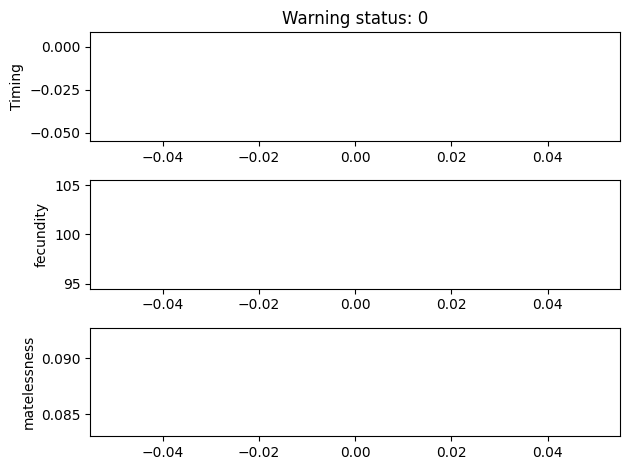

generation 1


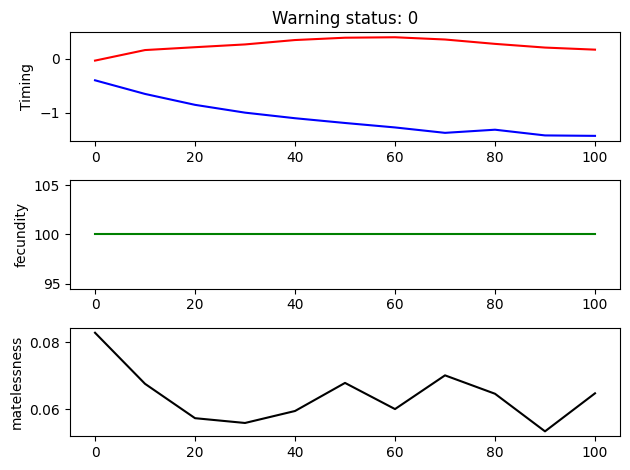

generation 101


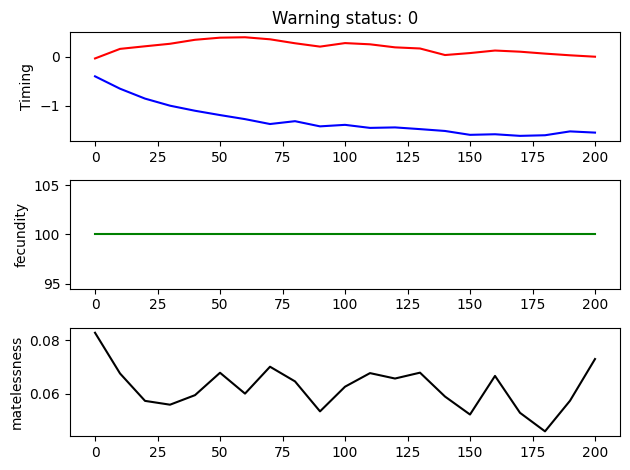

generation 201


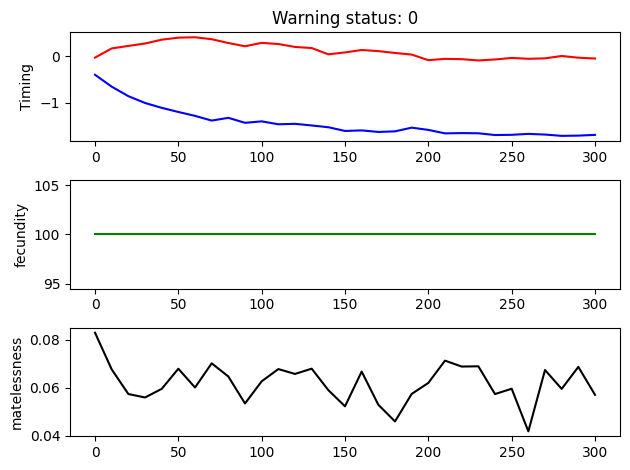

generation 301


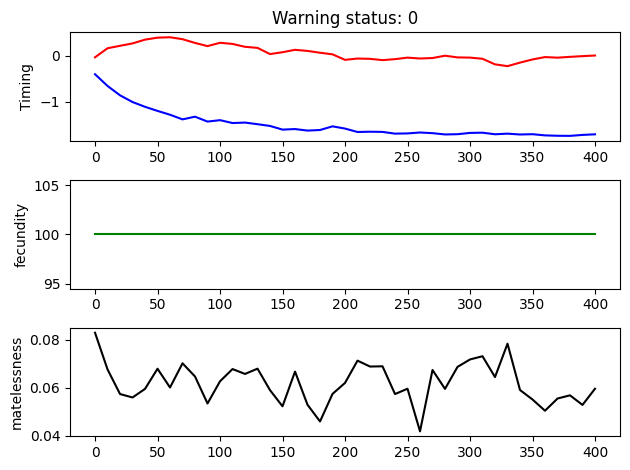

generation 401


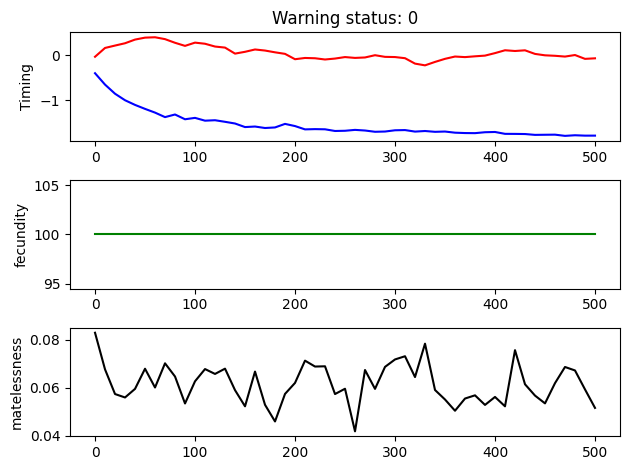

generation 501


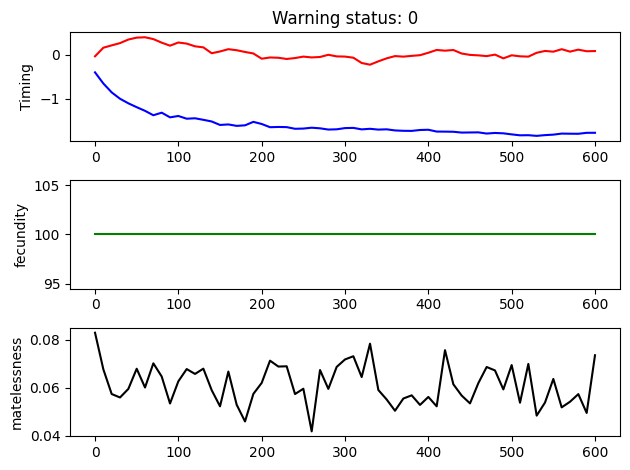

generation 601


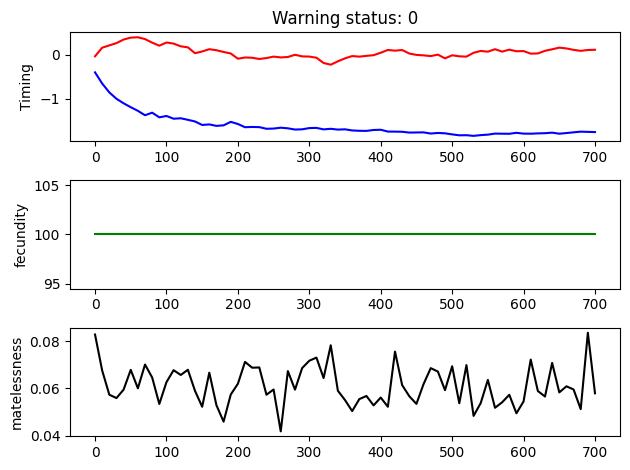

generation 701


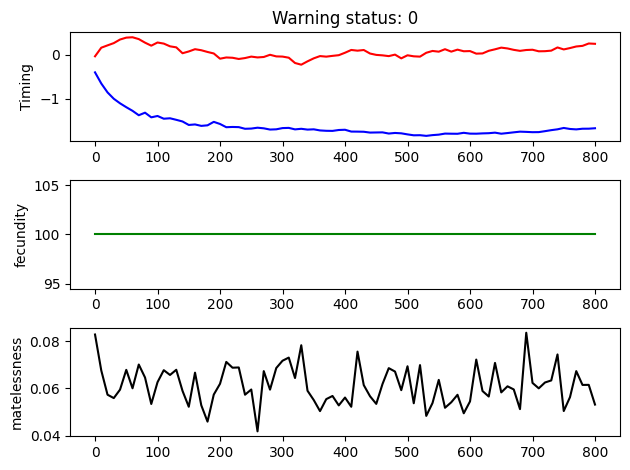

generation 801


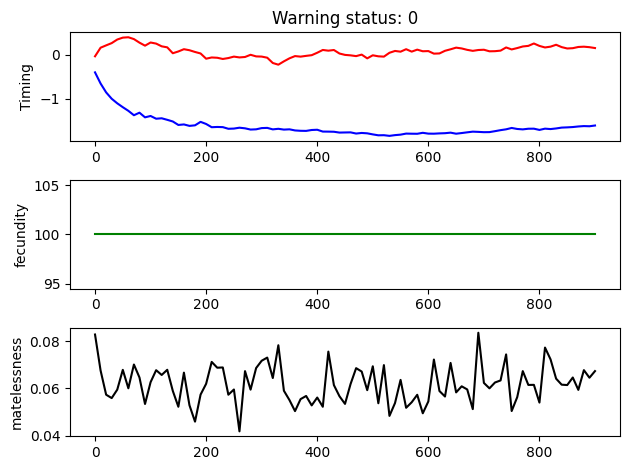

generation 901


In [13]:
def run_simulation_for_k_generations(data, parameters_instance):

    pop_initial = initialise_population(parameters_instance.popsize, parameters_instance)

    for k in range(1, parameters_instance.generations + 1):

        pop = pop_initial
        phenotype = population_phenotypes(pop, parameters_instance)
        emergencetime = emergencesample(phenotype)
        deathtime = population_deathtime(emergencetime, pop)

        T_encounter, who_encounter, flag = track_encounter_for_population(pop, emergencetime, deathtime, parameters_instance)
        mateidentity, relativefecundity, warning, extinction_status = mating_assignment_population(pop, T_encounter, who_encounter, flag, parameters_instance)    


        if extinction_status == 1:
            break

        data_collection(data, k, pop, relativefecundity, mateidentity,parameters_instance)

        
        if (k-1)/10==math.floor((k-1)/10):
            data = data_collection(data, k, pop, relativefecundity, mateidentity,parameters_instance)

            if (k-1)/100== math.floor((k-1)/100):
                
                plotting(data, warning, k)
        
        
        pop_next_gen = offspring_population(pop, mateidentity, relativefecundity, parameters_instance)
        pop = pop_next_gen

run_simulation_for_k_generations(data, parameters_instance)
# print(data, "data")
# print("generation over, onto next")



    

# print('----final---')
